     time_s  raw16_hex  raw16_hex
0  0.008829      0x168        360
1  0.009122      0x173        371
2  0.009145      0x173        371
3  0.009167      0x173        371
4  0.009189      0x173        371
     time_s  raw16_hex  raw16_hex  counts
0  0.008829      0x168        360     360
1  0.009122      0x173        371     371
2  0.009145      0x173        371     371
3  0.009167      0x173        371     371
4  0.009189      0x173        371     371


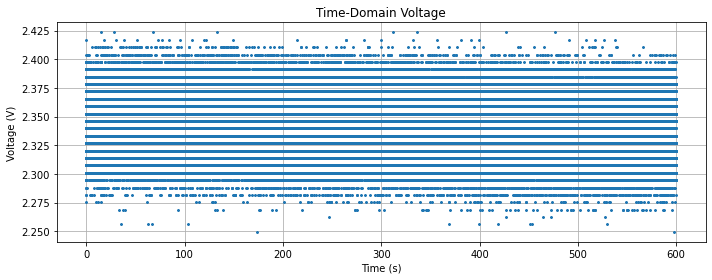

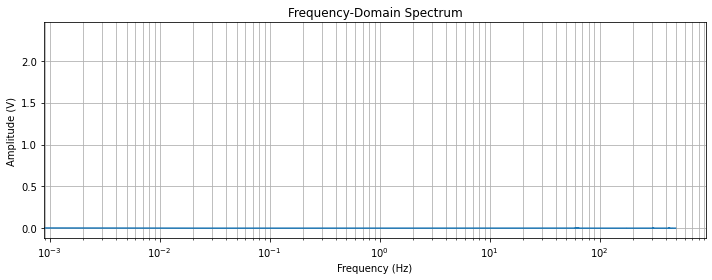

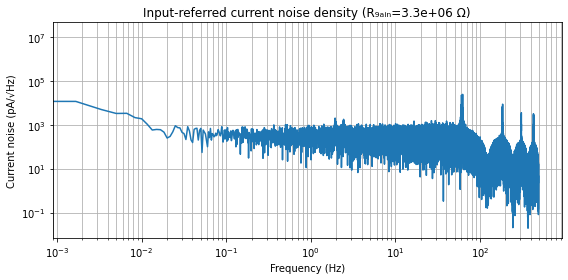

In [3]:
#!/usr/bin/env python3
"""
adc_analysis.py

Read ADC log (time, raw16 hex), convert to voltage, and plot:
  1. Time-domain voltage
  2. Frequency-domain magnitude spectrum
  3. Input-referred current noise spectrum (R_gain = 3.3 MΩ)

Usage:
    python adc_analysis.py adc_log.txt
"""

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

def load_data(filename):
    # Expect two columns: time_s, raw16_hex
    df = pd.read_csv(filename, comment='#')
    # parse hex string to integer
    df['raw16_hex'] = df[' raw16_hex'].apply(lambda x: int(str(x).strip(), 16))
    print(df.head())
    # ADS1015 12-bit is high-aligned in 16 bits → shift down 4
    df['counts'] = df['raw16_hex']
    print(df.head())
    # convert counts to voltage: LSB = 2.048 V / 2048 = 0.001 V
    df['voltage'] = df['counts'] /512.0 * 3.3
    return df

def plot_time_domain(df):
    plt.figure(figsize=(10,4))
    plt.plot(df['time_s'], df['voltage'], '.', markersize=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Time-Domain Voltage')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_frequency_domain(df):
    # compute sampling rate
    dt = np.median(np.diff(df['time_s']))
    fs = 1.0 / dt
    y = df['voltage']# - df['voltage'].mean()
    y = df['voltage'].to_numpy(dtype=float)
    N = len(y)
    yf = rfft(y)
    xf = rfftfreq(N, dt)

    plt.figure(figsize=(10,4))
    plt.semilogx(xf, np.abs(yf)/N)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (V)')
    plt.title('Frequency-Domain Spectrum')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()

    return xf, yf, N, dt

def plot_current_noise(xf, yf, N, dt, R_gain=3.3e6):
    """
    xf   -- frequencies returned by rfftfreq
    yf   -- complex FFT bins returned by rfft
    N    -- length of the time-series
    dt   -- sampling interval in seconds
    R_gain -- transimpedance gain in ohms
    """

    # 1) voltage spectrum (V) per bin:
    V_spec = np.abs(yf) / N

    # 2) convert to current spectrum (A) per bin:
    I_spec = V_spec / R_gain

    # 3) bandwidth per FFT bin (Hz):
    df = 1.0 / (N * dt)

    # 4) convert to spectral density (A/√Hz):
    I_density = I_spec / np.sqrt(df)

    # 5) convert to pA/√Hz:
    I_density_pA = I_density * 1e12

    plt.figure(figsize=(8,4))
    plt.loglog(xf, I_density_pA)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Current noise (pA/√Hz)')
    plt.title(f'Input-referred current noise density (R₉ₐᵢₙ={R_gain:.1e} Ω)')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()


def main():
    if len(sys.argv) != 2:
        print(f"Usage: {sys.argv[0]} adc_log.txt")
        sys.exit(1)

    filename = 'adc_log.txt'
    df = load_data(filename)

    # Plot 1: time domain
    plot_time_domain(df)

    # Plot 2: frequency domain
    xf, yf, N, dt = plot_frequency_domain(df)

    # Plot 3: input-referred current noise
    plot_current_noise(xf, yf, N, dt, R_gain=3.3e6)

main()

     time_s  raw16_hex  raw16_hex
0  0.008829      0x168        360
1  0.009122      0x173        371
2  0.009145      0x173        371
3  0.009167      0x173        371
4  0.009189      0x173        371
     time_s  raw16_hex  raw16_hex  counts
0  0.008829      0x168        360     360
1  0.009122      0x173        371     371
2  0.009145      0x173        371     371
3  0.009167      0x173        371     371
4  0.009189      0x173        371     371


AttributeError: Text.set() got an unexpected keyword argument 'fontwieght'

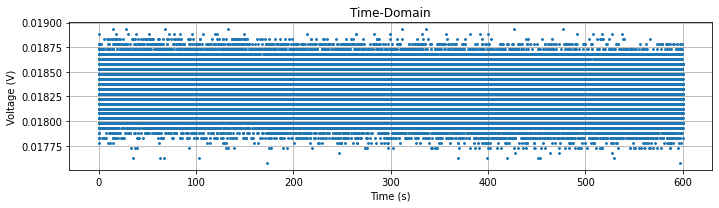

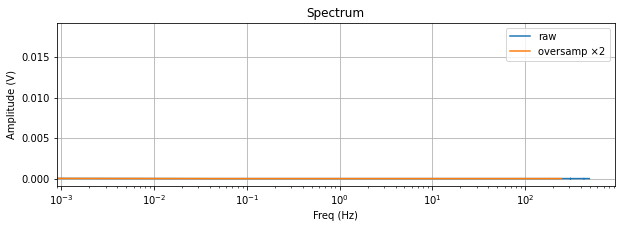

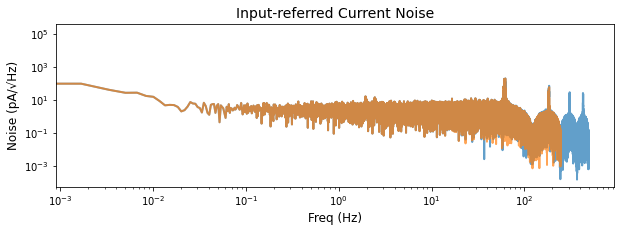

In [4]:
#!/usr/bin/env python3
"""
adc_analysis.py

Read ADC log (time_s, raw16 hex), convert to voltage, and plot:
  1. Time-domain voltage
  2. Frequency-domain magnitude spectrum
  3. Input-referred current noise spectrum (R_gain = 3.3 MΩ),
     with and without oversampling/decimation.

Usage:
    python adc_analysis.py adc_log.txt
"""

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq


def load_data(filename):
    # Expect two columns: time_s, raw16_hex
    df = pd.read_csv(filename, comment='#')
    # parse hex string to integer
    df['raw16_hex'] = df[' raw16_hex'].apply(lambda x: int(str(x).strip(), 16))
    print(df.head())
    # ADS1015 12-bit is high-aligned in 16 bits → shift down 4
    df['counts'] = df['raw16_hex']
    print(df.head())
    # convert counts to voltage: LSB = 2.048 V / 2048 = 0.001 V
    df['voltage'] = df['counts'] / (2.0**(16)) * 3.3
    return df


def plot_time_domain(df):
    plt.figure(figsize=(10, 3))
    plt.plot(df['time_s'], df['voltage'], '.', ms=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Time-Domain')
    plt.grid(True)
    plt.tight_layout()


def plot_frequency_domain(y, dt, label):
    N = len(y)
    yf = rfft(y)
    xf = rfftfreq(N, dt)
    amp = np.abs(yf)/N
    plt.semilogx(xf, amp, label=label)
    return xf, yf


def plot_current_noise(xf, yf, N, dt, R_gain, label):
    # voltage spectrum per bin
    V_spec = np.abs(yf)/N
    # current spectrum per bin
    I_spec = V_spec / R_gain
    # bin bandwidth
    df = 1.0/(N*dt)
    # spectral density A/√Hz
    I_den = I_spec/np.sqrt(df)
    # pA/√Hz
    I_den_pA = I_den*1e12
    plt.loglog(xf, I_den_pA, label=label, lw=2, alpha=0.7)


def oversample_and_decimate(voltage, M):
    # truncate to integer multiple of M
    L = len(voltage)//M * M
    v = voltage[:L].reshape(-1, M)
    # average blocks
    return v.mean(axis=1)


def main():
    filename = "adc_log.txt"
    df = load_data(filename)

    # time-domain
    plot_time_domain(df)

    # prepare original y & dt
    y = df['voltage'].to_numpy(dtype=float)
    dt = np.median(np.diff(df['time_s']))

    # frequency-domain plot
    plt.figure(figsize=(10, 3))
    xf_orig, yf_orig = plot_frequency_domain(y, dt, label='raw')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Amplitude (V)')
    plt.title('Spectrum')
    plt.grid(True)
    plt.legend()

    # oversample+decimate by M
    M = 2
    y_dec = oversample_and_decimate(y, M)
    dt_dec = dt * M

    # freq-domain of decimated
    plot_frequency_domain(y_dec, dt_dec, label=f'oversamp ×{M}')
    plt.legend()

    # current noise plot
    plt.figure(figsize=(10, 3))
    N = len(y)
    plot_current_noise(xf_orig, yf_orig, N, dt, 3.3e6, label='raw')
    N2 = len(y_dec)
    yf2 = rfft(y_dec)
    xf2 = rfftfreq(N2, dt_dec)
    plot_current_noise(xf2, yf2, N2, dt_dec, 3.3e6, label=f'oversamp ×{M}')
    plt.xlabel('Freq (Hz)', fontsize=12)
    plt.ylabel('Noise (pA/√Hz)', fontsize=12)
    plt.title('Input-referred Current Noise', fontsize=14, fontwieght = 'bold')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()

    plt.show()


main()

Applying EMA with alpha=0.5


/var/folders/2_/4cdvst0j6xb7rhsfnl56z0540000gn/T/ipykernel_10875/494115222.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


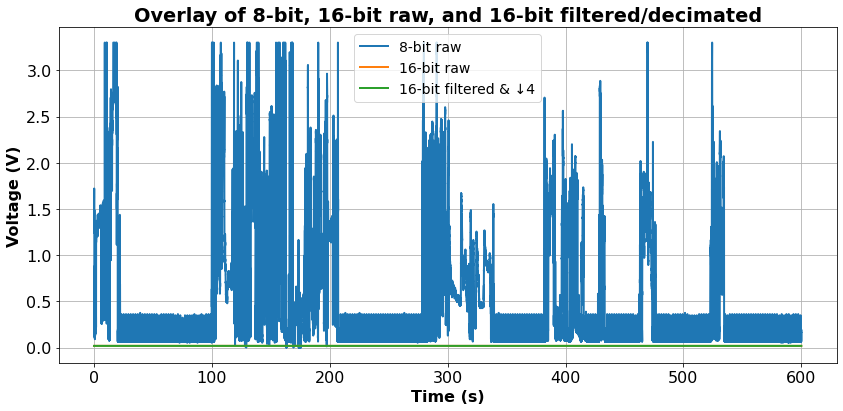

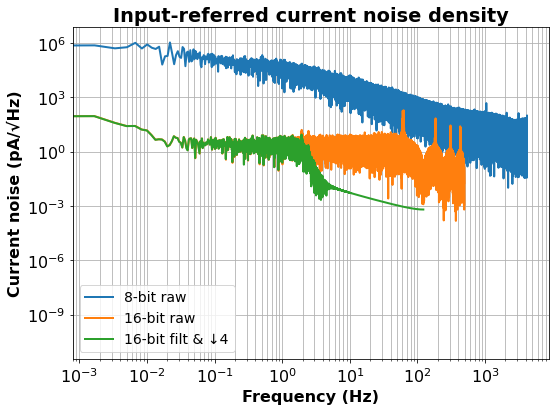

Minimum detectable RMS current in 0–1.0 Hz:
  8-bit raw:    139470.419 pA RMS
  16-bit raw:   5.522 pA RMS
  16-bit filt:  5.471 pA RMS


In [5]:
#!/usr/bin/env python3
"""
plot_two_signals_with_noise.py

Read an 8-bit ADC log and a 16-bit ADC log, compute an oversampled & low-pass filtered version of the
16-bit data, and produce:

  1) Overlay time-domain plot of
       • 8-bit raw
       • 16-bit raw
       • 16-bit filtered & decimated
  2) Input-referred current noise density (pA/√Hz) for each trace
  3) Print minimum detectable current (RMS) in the 0–1 Hz band for each

Usage:
    python plot_two_signals_with_noise.py eight_bit.txt sixteen_bit.txt
"""
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, butter, filtfilt
from scipy.fft import rfft, rfftfreq

# ––– User parameters –––#
VREF_8BIT = 3.3       # V
VREF_16BIT = 3.3       # V
DECIMATE_FACTOR = 4         # oversample/decimation factor
LP_CUTOFF_HZ = 2        # low-pass cutoff for filtered trace (Hz)
R_GAIN = 3.3e6     # Ω, transimpedance gain
BANDWIDTH_HZ = 1.0       # Hz band over which to integrate noise

# publication style
plt.rcParams.update({
    'font.size': 16,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'lines.linewidth': 2,
    'legend.fontsize': 14,
    'figure.figsize': (12, 6),
})


def load_8bit(fn):
    df = pd.read_csv(fn, comment='#')
    if df[' raw16_hex'].dtype == object:
        df['raw8'] = df[' raw16_hex'].apply(lambda x: int(str(x).strip(), 16))
    df['volt8'] = df['raw8']/255.0 * VREF_8BIT
    return df


def load_16bit(fn):
    df = pd.read_csv(fn, comment='#')
    if df[' raw16_hex'].dtype == object:
        df['raw16'] = df[' raw16_hex'].apply(lambda x: int(str(x).strip(), 16))
    df['volt16'] = df['raw16']/65535.0 * VREF_16BIT
    return df


def apply_ema(data: np.ndarray, alpha: float) -> np.ndarray:
    """
    Exponential moving average.
    data: 1D array of the signal
    alpha: smoothing factor in (0,1], higher = more responsive
    """
    print(f"Applying EMA with alpha={alpha}")
    ema = np.empty_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

def lowpass(time, volt, cutoff_hz, order=4):
    dt = np.median(np.diff(time))
    fs = 1.0/dt
    nyq = fs/2
    b, a = butter(order, cutoff_hz/nyq)
    filtdata = filtfilt(b, a, volt)

    # apply a exponential moving average to the filtered data
    ema_filt_data = apply_ema(filtdata, 0.5)
    return ema_filt_data


def compute_noise_density(time, volt):
    volt = np.asarray(volt, dtype=float)
    # FFT
    dt = np.median(np.diff(time))
    N = len(volt)
    yf = rfft(volt - np.mean(volt))
    xf = rfftfreq(N, dt)
    # voltage spectrum per bin
    Vspec = np.abs(yf)/N
    # current spec per bin
    Ispec = Vspec/R_GAIN
    # bin bandwidth
    df = 1.0/(N*dt)
    # density A/√Hz
    Idens = Ispec/np.sqrt(df)
    # to pA/√Hz
    return xf, Idens*1e12


def integrate_rms(xf, dens, fmax):
    df = xf[1]-xf[0]
    mask = (xf >= 0) & (xf <= fmax)
    # RMS = sqrt( ∑ density^2 * df )
    return np.sqrt(np.sum(dens[mask]**2 * df))


def main():
    fn8 = 'adc_log_8bitADC.txt'
    fn16 = 'adc_log.txt'

    df8 = load_8bit(fn8)
    df16 = load_16bit(fn16)

    # make filtered+decimated 16-bit
    filt16 = lowpass(df16['time_s'].values,
                     df16['volt16'].values, LP_CUTOFF_HZ)
    dec16 = decimate(filt16, DECIMATE_FACTOR, ftype='iir')
    time16_dec = df16['time_s'].values[::DECIMATE_FACTOR]

    # overlay time-domain
    plt.plot(df8['time_s'],  df8['volt8'],    'C0', label='8-bit raw')
    plt.plot(df16['time_s'], df16['volt16'], 'C1', label='16-bit raw')
    plt.plot(time16_dec,     dec16,          'C2',
             label=f'16-bit filtered & ↓{DECIMATE_FACTOR}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Overlay of 8-bit, 16-bit raw, and 16-bit filtered/decimated')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute & plot noise density
    xf8,  nd8 = compute_noise_density(df8['time_s'],  df8['volt8'])
    xf16, nd16 = compute_noise_density(df16['time_s'], df16['volt16'])
    xfD,  ndD = compute_noise_density(time16_dec,     dec16)
    
    plt.figure(figsize=(8,6))
    plt.loglog(xf8,  nd8,  'C0', label='8-bit raw')
    plt.loglog(xf16, nd16, 'C1', label='16-bit raw')
    plt.loglog(xfD,  ndD,  'C2', label=f'16-bit filt & ↓{DECIMATE_FACTOR}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Current noise (pA/√Hz)')
    plt.title('Input-referred current noise density')
    plt.legend()
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.savefig('input_referred_current_noise.png', dpi=300)
    plt.show()

    # integrate RMS in 0–1 Hz
    i8 = integrate_rms(xf8,  nd8,  BANDWIDTH_HZ)
    i16 = integrate_rms(xf16, nd16, BANDWIDTH_HZ)
    iD = integrate_rms(xfD,  ndD,  BANDWIDTH_HZ)
    print(f"Minimum detectable RMS current in 0–{BANDWIDTH_HZ} Hz:")
    print(f"  8-bit raw:    {i8:.3f} pA RMS")
    print(f"  16-bit raw:   {i16:.3f} pA RMS")
    print(f"  16-bit filt:  {iD:.3f} pA RMS")


if __name__ == '__main__':
    main()